# BIZ 프로젝트 : 부실기업 예측 모형에 관한 연구

## Step3 : 모델링 page2

주요 과제 : 21,22(2개년도)년도 GRU 모델간 성능 비교

### 0. 라이브러리 및 데이터 불러오기

라이브러리 불러오기

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, LSTM, GRU, Reshape
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

폰트 지정

In [2]:
import platform
from matplotlib import rc

# 운영 체제에 따라 폰트 설정
if platform.system() == 'Windows':  # Windows 환경
    rc('font', family='Malgun Gothic')  # 맑은 고딕

# 음수 표시 가능하도록 설정
plt.rcParams['axes.unicode_minus'] = False

데이터 불러오기(21 to 22 2개년도 데이터)

In [3]:
RANDOM_STATE = 110
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

data_21to22 = pd.read_csv("../../project/data/data_21to22.csv", encoding='utf-8-sig', low_memory=False)
print(data_21to22.shape)

(27603, 90)


타겟비율 시각화

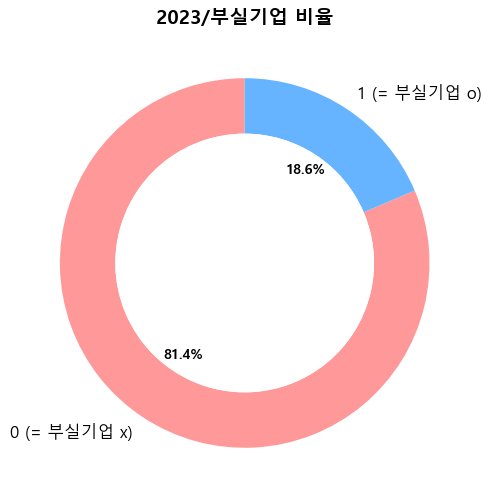

In [4]:
# '2023/부실기업' 비율 계산
value_counts = data_21to22['2023/부실기업'].value_counts()
labels = ['1 (= 부실기업 o)' if label == 1 else '0 (= 부실기업 x)' for label in value_counts.index]
sizes = value_counts.values

# 색상 설정
colors = ['#ff9999','#66b3ff']

# 도넛 차트 시각화
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))

wedges, texts, autotexts = ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.3))

# 도넛 차트의 가운데에 텍스트 추가
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# 텍스트 스타일 설정
plt.setp(autotexts, size=10, weight="bold", color="black")
plt.setp(texts, size=12)

# 차트 제목 추가
plt.title('2023/부실기업 비율', fontsize=14, weight='bold')

# 차트 표시
plt.show()

데이터 불균형 -> 평가지표로 accuracy(정확도)가 아닌 F1-score를 기준으로 한다.

### 1. 데이터 추가 전처리

In [5]:
# 종속 변수 설정
y = data_21to22['2023/부실기업']

# 연도별 특성 분리
X_2021 = data_21to22.filter(like='2021')  # 2021년 데이터
X_2022 = data_21to22.filter(like='2022')  # 2022년 데이터

# 재무비율 추출 함수
def extract_ratio_columns(df, year):
    return df.columns.str.replace(f'{year}/', '')

# 2021년과 2022년의 재무비율 추출
ratios_2021 = extract_ratio_columns(X_2021, '2021')
ratios_2022 = extract_ratio_columns(X_2022, '2022')

# 공통 재무비율 찾기
common_ratios = ratios_2021.intersection(ratios_2022)

# 공통 재무비율을 포함하는 변수명 생성
common_columns_2021 = [f'2021/{ratio}' for ratio in common_ratios]
common_columns_2022 = [f'2022/{ratio}' for ratio in common_ratios]

# 공통 변수만 사용하여 데이터 결합
X_2021_common = X_2021[common_columns_2021]
X_2022_common = X_2022[common_columns_2022]

# 전체 특성 결합 (타임 스텝을 위해 배열로 변환)
X_common = pd.concat([X_2021_common, X_2022_common], axis=1)

# 데이터 분할 (70:30 비율)
X_common_train, X_common_test, y_train, y_test = train_test_split(X_common, y, test_size=0.3, random_state=RANDOM_STATE)

# 데이터 정규화
scaler_common = StandardScaler()
X_common_train_scaled = scaler_common.fit_transform(X_common_train)
X_common_test_scaled = scaler_common.transform(X_common_test)

# 변수명을 유지하기 위해 DataFrame으로 변환
X_common_train_scaled_df = pd.DataFrame(X_common_train_scaled, columns=X_common_train.columns)
X_common_test_scaled_df = pd.DataFrame(X_common_test_scaled, columns=X_common_test.columns)

# 타임 스텝 설정
timesteps = 2  # 2021년과 2022년으로 2개의 타임 스텝으로 설정  # (샘플 수, 타임 스텝, 특성 수)
X_train_lstm = X_common_train_scaled_df.values.reshape((X_common_train_scaled_df.shape[0], timesteps, -1)) 
X_test_lstm = X_common_test_scaled_df.values.reshape((X_common_test_scaled_df.shape[0], timesteps, -1))

In [6]:
# 타임 스텝 확인
print("X_train_lstm shape:", X_train_lstm.shape)
print("X_test_lstm shape:", X_test_lstm.shape)

# 첫 번째 샘플의 타임 스텝별 데이터 확인
print("첫 번째 샘플의 첫 번째 타임 스텝 데이터:", X_train_lstm[0, 0, :])
print("첫 번째 샘플의 두 번째 타임 스텝 데이터:", X_train_lstm[0, 1, :])

X_train_lstm shape: (19322, 2, 21)
X_test_lstm shape: (8281, 2, 21)
첫 번째 샘플의 첫 번째 타임 스텝 데이터: [ 0.03807207 -0.0020328   0.05400356  0.05899398  0.07017119  0.14827777
  0.00180214  0.61243826 -0.33427654 -0.185362   -0.19290163 -0.19358192
 -0.03935053 -0.35014204  0.41301943  0.25458916  0.33200608 -0.04324597
 -0.03086146 -0.12714346 -0.22720773]
첫 번째 샘플의 두 번째 타임 스텝 데이터: [-0.54167093 -0.62132018 -0.51073733 -0.55508638 -0.57985577  0.097176
 -0.0018005  -0.13981697 -0.35060469 -0.18735672 -0.19095395 -0.19360187
 -0.06447123 -0.34301056  0.35340432  0.24664365  0.25629906 -0.07094113
 -0.02741867 -0.12251024 -0.21648227]


In [7]:
common_ratios

Index(['총자본영업이익율', '기업법인세비용차감전순이익율', '경영자본영업이익율', '자본금법인세비용차감전순이익율', '자본금순이익율',
       '매출액법인세비용차감전순이익율', '조세/조세차감전순이익비율', '차입금평균이자율', '금융비용/총비용비율',
       '영업이익이자보상비율', '법인세차감전순이익이자보상비율', 'EBITDA대금융비용', '현금비율', '유동부채비율',
       '순운전자본/총자본비율', '사내유보율', '유보액/총자산비율', '순이익(종업원1인당)', '법인세차감전순이익(구성비)',
       '금융비용(구성비)', '임차료(구성비)'],
      dtype='object')

---

### 2. 모델링

GRU 모델 성능 비교

- GRU 노드 수: 64, 층 수: 1
- GRU 노드 수: 64, 층 수: 2
- GRU 노드 수: 128, 층 수: 1
- GRU 노드 수: 128, 층 수: 2
- GRU 노드 수: 256, 층 수: 1
- GRU 노드 수: 256, 층 수: 2

In [8]:
from tensorflow.keras.callbacks import EarlyStopping

# 모델 학습 및 평가 함수
def train_and_evaluate_gru_model(X_train, y_train, X_test, y_test, gru_units, num_layers):
    model = Sequential()
    for i in range(num_layers):
        if i == 0:
            model.add(GRU(gru_units, activation='relu', return_sequences=(i != num_layers - 1), input_shape=(X_train.shape[1], X_train.shape[2])))
        else:
            model.add(GRU(gru_units, activation='relu', return_sequences=(i != num_layers - 1)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    
    # 조기 종료 콜백 설정
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stopping])
    predictions_proba = model.predict(X_test)
    predictions = (predictions_proba > 0.5).astype(int)
    
    accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
    f1 = f1_score(y_test, predictions)
    
    return history, accuracy, f1, predictions_proba

# 다양한 모델 구조와 노드 수에 대한 성능 비교
gru_configs = [
    {'gru_units': 64, 'num_layers': 1},
    {'gru_units': 64, 'num_layers': 2},
    {'gru_units': 128, 'num_layers': 1},
    {'gru_units': 128, 'num_layers': 2},
    {'gru_units': 256, 'num_layers': 1},
    {'gru_units': 256, 'num_layers': 2},
]

results = []

for config in gru_configs:
    history, accuracy, f1, predictions_proba = train_and_evaluate_gru_model(X_train_lstm, y_train, X_test_lstm, y_test, config['gru_units'], config['num_layers'])
    results.append({
        'config': config,
        'history': history,
        'accuracy': accuracy,
        'f1_score': f1,
        'predictions_proba': predictions_proba
    })
    print(f"Config: {config}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")

Epoch 1/50
484/484 [==============================] - 2s 2ms/step - loss: 0.2641 - accuracy: 0.8910 - val_loss: 0.2056 - val_accuracy: 0.9071
Epoch 2/50
484/484 [==============================] - 1s 1ms/step - loss: 0.1862 - accuracy: 0.9163 - val_loss: 0.1803 - val_accuracy: 0.9213
Epoch 3/50
484/484 [==============================] - 1s 1ms/step - loss: 0.1671 - accuracy: 0.9270 - val_loss: 0.1722 - val_accuracy: 0.9226
Epoch 4/50
484/484 [==============================] - 1s 1ms/step - loss: 0.1570 - accuracy: 0.9328 - val_loss: 0.1632 - val_accuracy: 0.9257
Epoch 5/50
484/484 [==============================] - 1s 1ms/step - loss: 0.1507 - accuracy: 0.9360 - val_loss: 0.1566 - val_accuracy: 0.9335
Epoch 6/50
484/484 [==============================] - 1s 1ms/step - loss: 0.1453 - accuracy: 0.9372 - val_loss: 0.1542 - val_accuracy: 0.9301
Epoch 7/50
484/484 [==============================] - 1s 1ms/step - loss: 0.1412 - accuracy: 0.9373 - val_loss: 0.1539 - val_accuracy: 0.9301
Epoch 

모델 성능 시각화

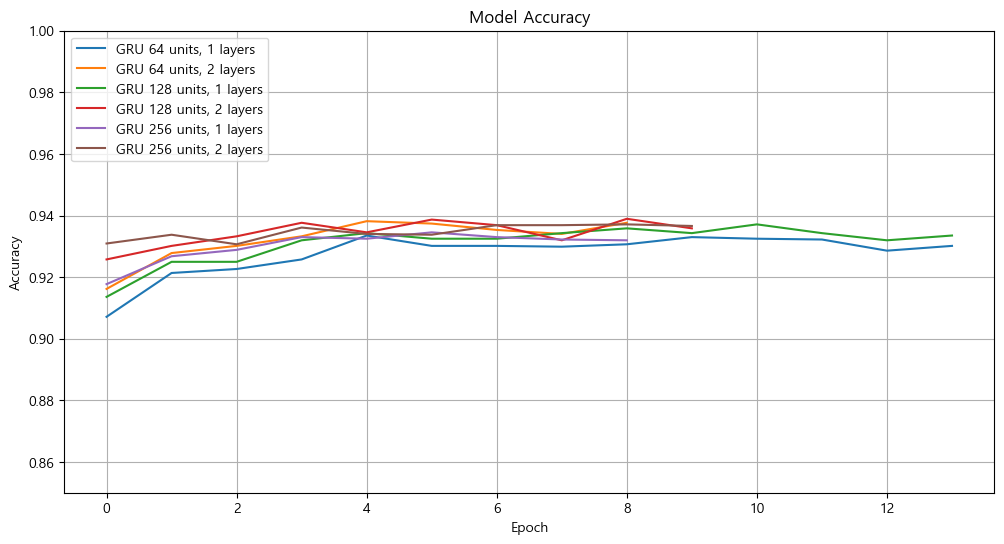

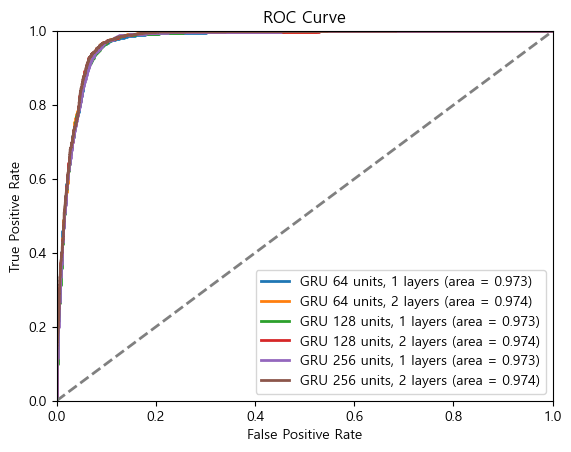

In [9]:
# Accuracy 시각화
plt.figure(figsize=(12, 6))
for result in results:
    plt.plot(result['history'].history['val_accuracy'], label=f"GRU {result['config']['gru_units']} units, {result['config']['num_layers']} layers")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.ylim(0.85, 1)
plt.grid()
plt.show()

# ROC Curve 시각화
plt.figure()
for result in results:
    fpr, tpr, _ = roc_curve(y_test, result['predictions_proba'])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"GRU {result['config']['gru_units']} units, {result['config']['num_layers']} layers (area = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

auc 값 기준으로 <은닉층이 64노드로 2개의 층>, <은닉층이 128노드로 2개의 층>, <은닉층이 256노드로 2개의 층> 인 경우가 높다  
(6개의 모델을 성능 비교하였을때 거의 차이가 없음)

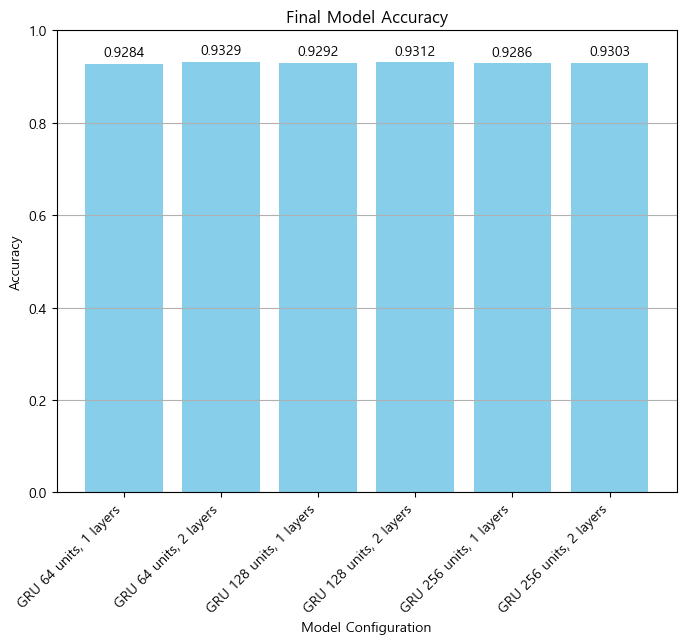

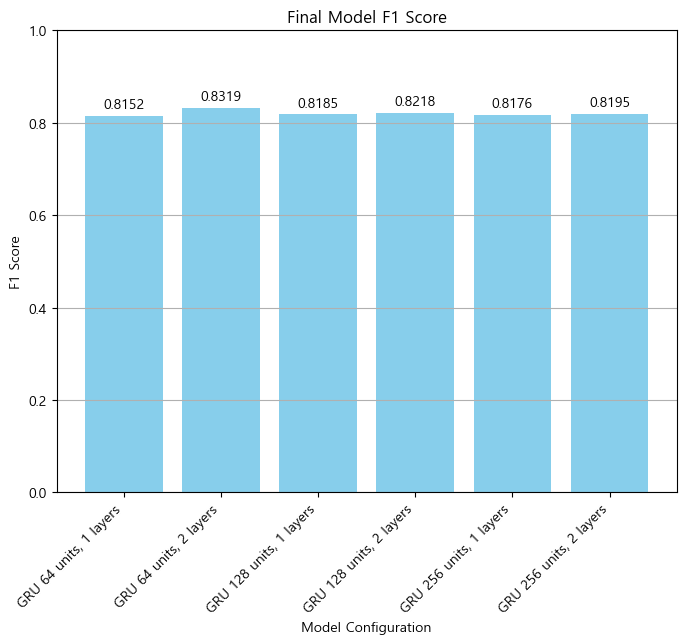

In [10]:
# 최종 모델의 F1 Score와 Accuracy 시각화
final_accuracies = [result['accuracy'] for result in results]
final_f1_scores = [result['f1_score'] for result in results]
configs = [f"GRU {result['config']['gru_units']} units, {result['config']['num_layers']} layers" for result in results]

# Accuracy 막대그래프
plt.figure(figsize=(8, 6))
bars = plt.bar(configs, final_accuracies, color='skyblue')
plt.title('Final Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Model Configuration')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.grid(axis='y')

# 막대 위에 성능 수치 표시
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.4f}', ha='center', va='bottom')

plt.show()

# F1 Score 막대그래프
plt.figure(figsize=(8, 6))
bars = plt.bar(configs, final_f1_scores, color='skyblue')
plt.title('Final Model F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Model Configuration')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.grid(axis='y')

# 막대 위에 성능 수치 표시
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.4f}', ha='center', va='bottom')

plt.show()

f1 값 기준으로 <은닉층이 64노드로 2개의 층> 인 모델의 성능이 높다

최종 GRU 모델 구축 ( node = 64 , layer = 2 )

최종적으로 은닉층이 64개의 노드의 2개의 층으로 구성된 GRU을 이용

In [11]:
# 모델 구축
model = Sequential()
model.add(GRU(64, activation='relu', return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(GRU(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# 조기 종료 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 모델 학습
history = model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stopping])

# 모델 예측
predictions_proba = model.predict(X_test_lstm)
predictions = (predictions_proba > 0.5).astype(int)

# 모델 평가
accuracy = model.evaluate(X_test_lstm, y_test, verbose=0)[1]
f1 = f1_score(y_test, predictions)

print(f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")

Epoch 1/50
484/484 [==============================] - 3s 3ms/step - loss: 0.2477 - accuracy: 0.8944 - val_loss: 0.1896 - val_accuracy: 0.9213
Epoch 2/50
484/484 [==============================] - 1s 2ms/step - loss: 0.1730 - accuracy: 0.9253 - val_loss: 0.1677 - val_accuracy: 0.9273
Epoch 3/50
484/484 [==============================] - 1s 2ms/step - loss: 0.1580 - accuracy: 0.9335 - val_loss: 0.1637 - val_accuracy: 0.9307
Epoch 4/50
484/484 [==============================] - 1s 2ms/step - loss: 0.1484 - accuracy: 0.9356 - val_loss: 0.1545 - val_accuracy: 0.9345
Epoch 5/50
484/484 [==============================] - 1s 2ms/step - loss: 0.1437 - accuracy: 0.9386 - val_loss: 0.1486 - val_accuracy: 0.9351
Epoch 6/50
484/484 [==============================] - 1s 2ms/step - loss: 0.1396 - accuracy: 0.9390 - val_loss: 0.1485 - val_accuracy: 0.9345
Epoch 7/50
484/484 [==============================] - 1s 2ms/step - loss: 0.1335 - accuracy: 0.9409 - val_loss: 0.1492 - val_accuracy: 0.9340
Epoch 

조기종료 코드 지우고 9 epoch으로 고정

In [12]:
# 모델 구축
model = Sequential()
model.add(GRU(64, activation='relu', return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(GRU(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# 모델 학습
history = model.fit(X_train_lstm, y_train, epochs=9, batch_size=32, verbose=1)

# 모델 예측
predictions_proba = model.predict(X_test_lstm)
predictions = (predictions_proba > 0.5).astype(int)

# 모델 평가
accuracy = model.evaluate(X_test_lstm, y_test, verbose=0)[1]
f1 = f1_score(y_test, predictions)

print(f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")

Epoch 1/9
604/604 [==============================] - 3s 2ms/step - loss: 0.2294 - accuracy: 0.9021
Epoch 2/9
604/604 [==============================] - 1s 2ms/step - loss: 0.1658 - accuracy: 0.9281
Epoch 3/9
604/604 [==============================] - 1s 2ms/step - loss: 0.1521 - accuracy: 0.9345
Epoch 4/9
604/604 [==============================] - 1s 2ms/step - loss: 0.1448 - accuracy: 0.9365
Epoch 5/9
604/604 [==============================] - 1s 2ms/step - loss: 0.1389 - accuracy: 0.9374
Epoch 6/9
604/604 [==============================] - 1s 2ms/step - loss: 0.1342 - accuracy: 0.9405
Epoch 7/9
604/604 [==============================] - 1s 2ms/step - loss: 0.1311 - accuracy: 0.9421
Epoch 8/9
604/604 [==============================] - 1s 2ms/step - loss: 0.1276 - accuracy: 0.9431
Epoch 9/9
259/259 [==============================] - 0s 872us/step
Accuracy: 0.9344, F1 Score: 0.8351


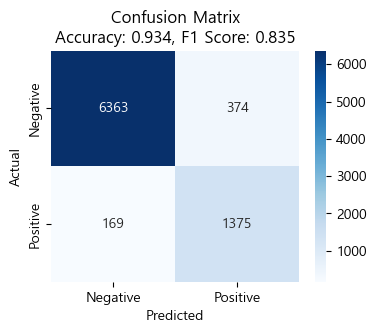

<Figure size 640x480 with 0 Axes>

In [13]:
# 혼동 행렬 출력
conf_matrix = confusion_matrix(y_test, predictions)

# 혼동 행렬 시각화
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.3f}, F1 Score: {f1:.3f}')
plt.show()

# 정확도와 F1 점수 출력
plt.figtext(0.5, -0.1, f'Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}', ha='center', va='center', fontsize=12)
plt.show()

# 모델 저장
# model.save('lstm_model.h5')

In [14]:
common_ratios

Index(['총자본영업이익율', '기업법인세비용차감전순이익율', '경영자본영업이익율', '자본금법인세비용차감전순이익율', '자본금순이익율',
       '매출액법인세비용차감전순이익율', '조세/조세차감전순이익비율', '차입금평균이자율', '금융비용/총비용비율',
       '영업이익이자보상비율', '법인세차감전순이익이자보상비율', 'EBITDA대금융비용', '현금비율', '유동부채비율',
       '순운전자본/총자본비율', '사내유보율', '유보액/총자산비율', '순이익(종업원1인당)', '법인세차감전순이익(구성비)',
       '금융비용(구성비)', '임차료(구성비)'],
      dtype='object')

이후:  
GRU 모델을 활용하여 부실기업 예측 대시보드 시각화

.